In [524]:
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

Get Stock Data from Yahoo Finance

In [599]:
ticker = ["^GSPC"]

temp = yf.download(ticker, start = "2000-01-01", end = "2025-01-01", group_by="ticker")

GSPC = temp["^GSPC"].drop(['Volume'], axis = 1)
GSPC = GSPC.dropna()

[*********************100%***********************]  1 of 1 completed


# Random Monthly buying Strategy

In [605]:
# Create a column with year-month information
GSPC['YearMonth'] = GSPC.index.to_period('M')

# Get unique months in the dataset
unique_months = GSPC['YearMonth'].unique()

# Create empty lists to store randomly selected data
random_dates = []
random_open_prices = []
random_close_prices = []

rng = np.random.RandomState(42) # So the results can be replicated

# For each month, select a random trading day
for month in unique_months:
    # Get all rows for this month
    month_data = GSPC[GSPC['YearMonth'] == month]
    
    # Select a random row
    random_row = month_data.sample(n=1, random_state = rng)
    
    # Store the information
    random_dates.append(random_row.index[0])
    random_open_prices.append(random_row['Open'].iloc[0])
    random_close_prices.append(random_row['Close'].iloc[0])

# Create DataFrame with randomly selected data
monthly_trades = pd.DataFrame({
    'Date': random_dates,
    'Open Price': random_open_prices,
    'Close Price': random_close_prices
})

# Set Date as index and sort chronologically
monthly_trades.set_index('Date', inplace=True)
monthly_trades.sort_index(inplace=True)

# Continue with the calculations
monthly_trades['Investment'] = monthly_investment
monthly_trades['Shares_Bought'] = monthly_trades['Investment'] / monthly_trades['Open Price']
monthly_trades['Cumul_Shares'] = monthly_trades['Shares_Bought'].cumsum()
monthly_trades['Cumul_Invested'] = monthly_trades['Investment'].cumsum()
monthly_trades['Portfolio Value'] = monthly_trades['Cumul_Shares'] * monthly_trades['Close Price']

monthly_trades.tail()

,Open Price,Close Price,Investment,Shares_Bought,Cumul_Shares,Cumul_Invested,Portfolio Value
Date,,,,,,,
2024-08-28,5624.51,5592.18,1000,0.18,185.16,296000,1035426.74
2024-09-19,5702.63,5713.64,1000,0.18,185.33,297000,1058917.73
2024-10-07,5737.80,5695.94,1000,0.17,185.51,298000,1056630.03
2024-11-01,5723.22,5728.80,1000,0.17,185.68,299000,1063726.70
2024-12-10,6057.59,6034.91,1000,0.17,185.85,300000,1121561.70


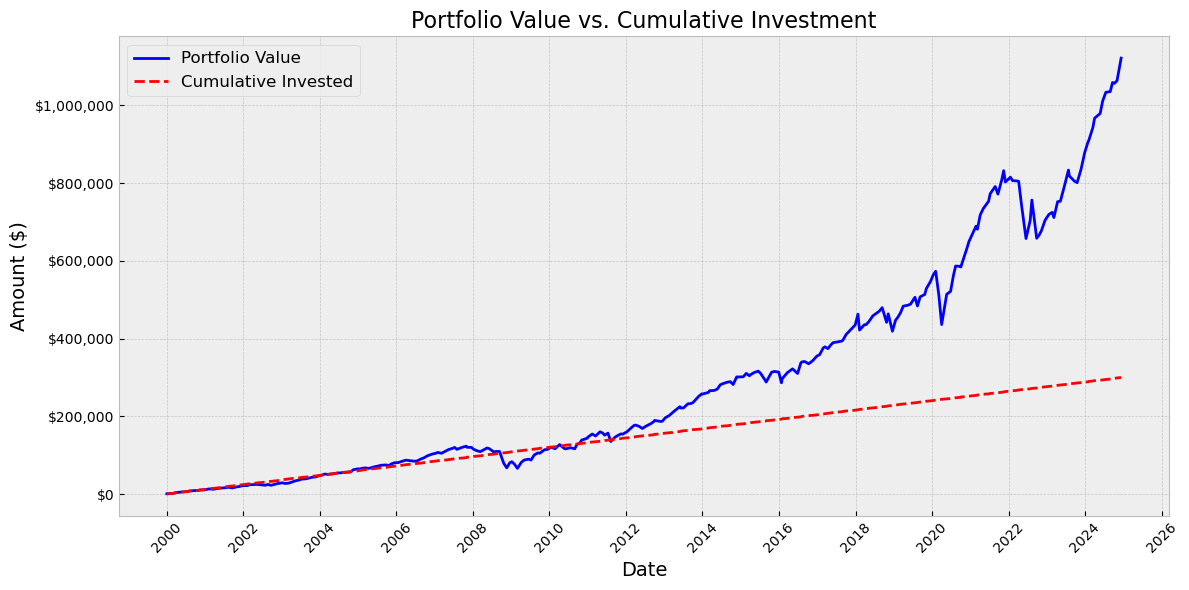

In [614]:
# Create a resampled DataFrame for plotting that shares the same index as monthly_trades
plot_data = monthly_trades[['Portfolio Value', 'Cumul_Invested']].copy()

# Now plot using plot_data which has both series with the same index
plt.figure(figsize=(12, 6))

# Plot the portfolio value
plt.plot(
    plot_data.index,
    plot_data['Portfolio Value'],
    'b-',
    linewidth=2,
    label='Portfolio Value'
)

# Plot the cumulative invested capital
plt.plot(
    plot_data.index,
    plot_data['Cumul_Invested'],
    'r--',
    linewidth=2,
    label='Cumulative Invested'
)

# Title, labels, grid
plt.title('Portfolio Value vs. Cumulative Investment', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Amount ($)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.xticks(rotation=45)

# Format y-axis to show dollar amounts
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, pos: f"${int(x):,}")
)

# Legend
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

# SMA Crossover Strategy

In [603]:
# 1) Calculate moving averages
GSPC["SMA_50"] = GSPC['Close'].rolling(window=50).mean()
GSPC["SMA_200"] = GSPC['Close'].rolling(window=200).mean()

# 2) Generate crossing signals more reliably
GSPC['Signal'] = 0
GSPC.loc[GSPC['SMA_50'] > GSPC['SMA_200'], 'Signal'] = 1  # Long signal
GSPC.loc[GSPC['SMA_50'] < GSPC['SMA_200'], 'Signal'] = -1  # Short signal

# Find where signal changes
GSPC['Signal_Change'] = GSPC['Signal'].diff().ne(0)
crossing_dates = GSPC[GSPC['Signal_Change'] & (GSPC['Signal'] != 0)].index

# 3) Generate trading signals
signals = []
for date in crossing_dates:
    if GSPC.loc[date, 'Signal'] == 1:
        signals.append((GSPC.index.get_loc(date), 'long'))  # Golden cross
    else:
        signals.append((GSPC.index.get_loc(date), 'short'))  # Death cross

# 4) Backtest loop
initial_balance = 300000 
balance = initial_balance
equity_times = []
equity_values = []
trades = []

for j in range(len(signals) - 1):
    entry_id, position = signals[j]
    exit_id, _ = signals[j + 1]
    
    entry_price = GSPC['Close'].iloc[entry_id]
    exit_price = GSPC['Close'].iloc[exit_id]
    
    # Correct calculation for long and short returns
    if position == 'long':
        return_pct = (exit_price - entry_price) / entry_price
    else:  # Short position - corrected calculation
        return_pct = (entry_price - exit_price) / entry_price
    
    profit = balance * return_pct
    balance += profit
    
    equity_times.append(GSPC.index[exit_id])
    equity_values.append(balance)
    
    trades.append({
        'Entry Date': GSPC.index[entry_id],
        'Position': position,
        'Entry Price': entry_price,
        'Exit Date': GSPC.index[exit_id],
        'Exit Price': exit_price,
        'Return (%)': return_pct * 100,
        'Balance After Trade': balance
    })

trades_df = pd.DataFrame(trades)

# Calculate statistics
total_trades = len(trades_df)
wins = trades_df['Return (%)'] > 0
losses = trades_df['Return (%)'] <= 0
num_wins = wins.sum()
num_losses = losses.sum()
win_rate = num_wins / total_trades * 100
avg_return = trades_df['Return (%)'].mean()

# Final equity
final_return = ((balance - initial_balance) / initial_balance) * 100

SMA_stats = pd.DataFrame({
    'Stats': [
        'Total Trades', 'Winning Trades', 'Losing Trades', 'Win Rate (%)',
        'Avg. Return per Trade (%)', 'Final Return (%)', 'Final Balance'],
    'Value': [
        total_trades,
        num_wins,
        num_losses,
        round(win_rate, 2),
        round(avg_return, 2),
        round(final_return, 2),
        round(balance, 2)
    ]
})

SMA_stats

,Stats,Value
0,Total Trades,22.00
1,Winning Trades,10.00
2,Losing Trades,12.00
3,Win Rate (%),45.45
4,Avg. Return per Trade (%),6.63
5,Final Return (%),196.07
6,Final Balance,888214.61


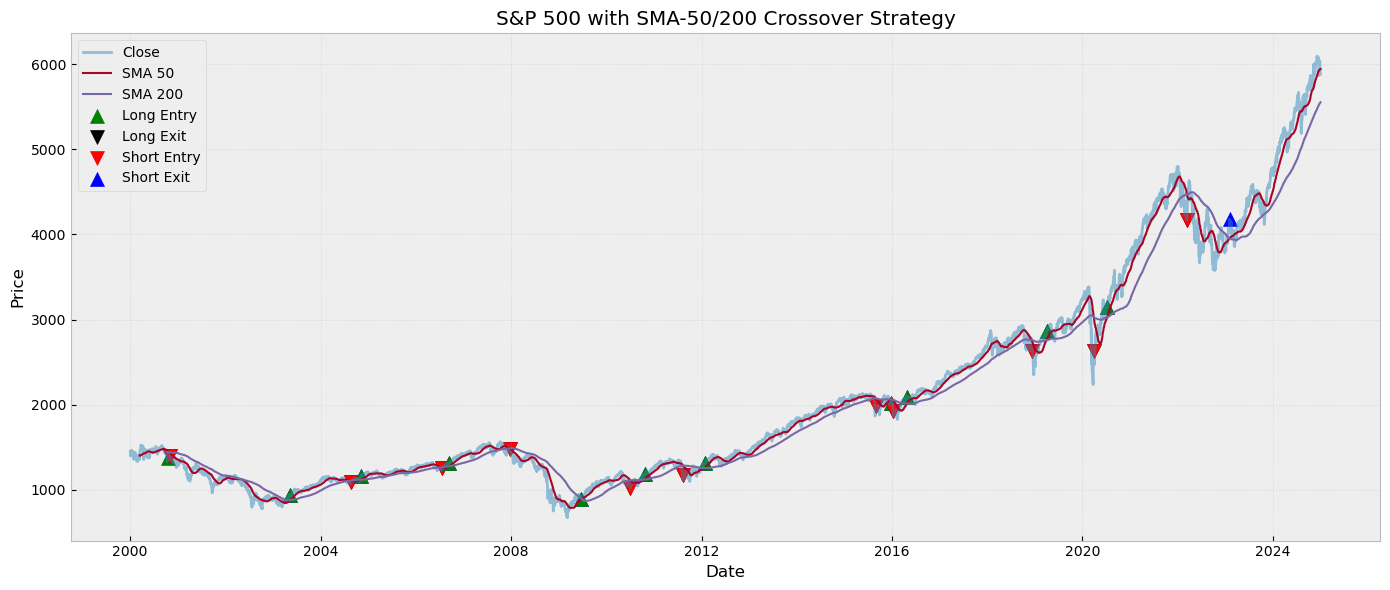

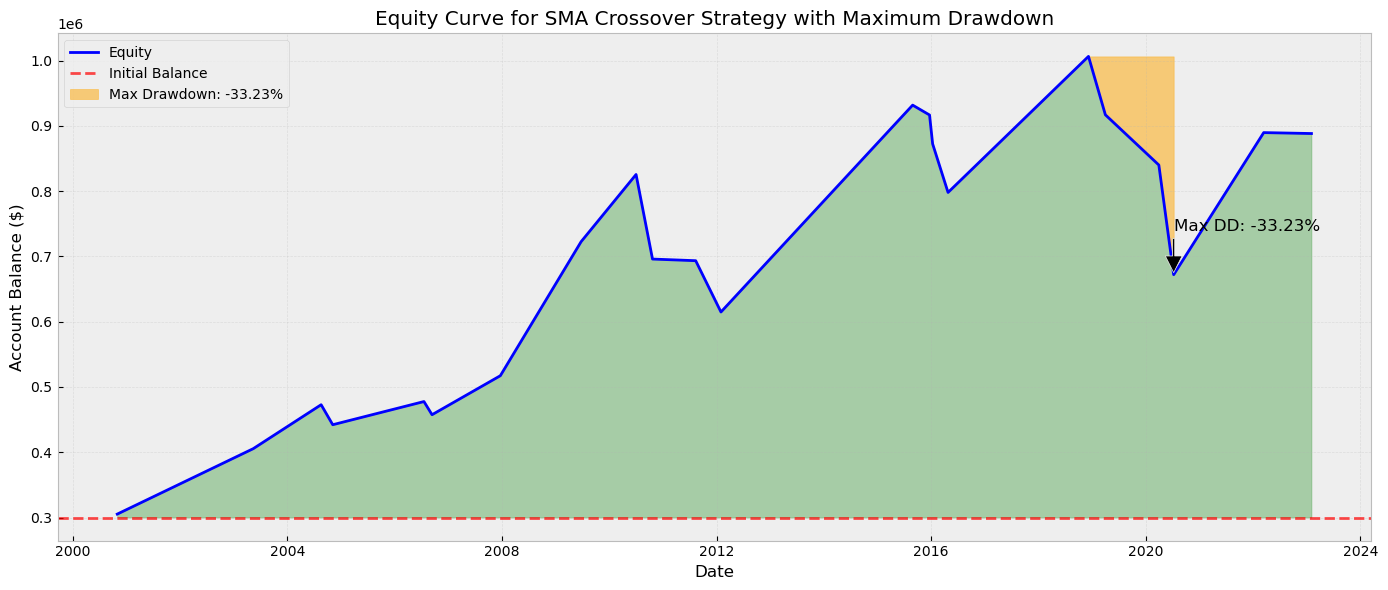

In [616]:
plt.figure(figsize=(14,6))

# 1) Plot price and SMAs
plt.plot(GSPC.index, GSPC['Close'], label='Close', alpha=0.5, linewidth=2)
plt.plot(GSPC.index, GSPC['SMA_50'], label='SMA 50', alpha=1, linewidth=1.5)
plt.plot(GSPC.index, GSPC['SMA_200'], label='SMA 200', alpha=1, linewidth=1.5)

# 2) Annotate each trade
for _, trade in trades_df.iterrows():  # Fixed the syntax error here (removed *)
    entry_dt = trade['Entry Date']
    exit_dt = trade['Exit Date']
    entry_px = trade['Entry Price']
    exit_px = trade['Exit Price']
    pos = trade['Position']
    
    # marker style
    if pos == 'long':
        plt.scatter(entry_dt, entry_px, marker='^', color='green', s=100, label='Long Entry')
        plt.scatter(exit_dt, exit_px, marker='v', color='black', s=100, label='Long Exit')
    else:
        plt.scatter(entry_dt, entry_px, marker='v', color='red', s=100, label='Short Entry')
        plt.scatter(exit_dt, exit_px, marker='^', color='blue', s=100, label='Short Exit')

# 3) Clean up legend (avoid duplicate labels)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')
plt.title('S&P 500 with SMA-50/200 Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Calculate running maximum for equity curve
running_max = np.maximum.accumulate(equity_values)
drawdowns = (equity_values - running_max) / running_max * 100  # Convert to percentage
max_drawdown = np.min(drawdowns)
max_dd_idx = np.argmin(drawdowns)
max_dd_start_idx = np.where(equity_values[:max_dd_idx] == running_max[max_dd_idx])[0][-1]

# Create equity curve plot with drawdown highlight
plt.figure(figsize=(14,6))
plt.plot(equity_times, equity_values, color='blue', linewidth=2, label='Equity')
plt.axhline(y=initial_balance, color='r', linestyle='--', alpha=0.7, label='Initial Balance')

# Fill profit/loss areas
plt.fill_between(equity_times, initial_balance, equity_values, where=(np.array(equity_values) >= initial_balance), 
                color='green', alpha=0.3)
plt.fill_between(equity_times, initial_balance, equity_values, where=(np.array(equity_values) < initial_balance), 
                color='red', alpha=0.3)

# Highlight the maximum drawdown period
plt.fill_between(equity_times[max_dd_start_idx:max_dd_idx+1], 
                equity_values[max_dd_start_idx:max_dd_idx+1], 
                running_max[max_dd_start_idx:max_dd_idx+1], 
                color='orange', alpha=0.5, label=f'Max Drawdown: {max_drawdown:.2f}%')

# Annotate the max drawdown
plt.annotate(f'Max DD: {max_drawdown:.2f}%',
             xy=(equity_times[max_dd_idx], equity_values[max_dd_idx]),
             xytext=(equity_times[max_dd_idx], equity_values[max_dd_idx] * 1.1),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=12)

plt.title('Equity Curve for SMA Crossover Strategy with Maximum Drawdown')
plt.xlabel('Date')
plt.ylabel('Account Balance ($)')
plt.legend(loc = 'upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

# Buy the dip Strategy

In [612]:
# In theory doing this strategy should lead to a greater ROI as your buying at disocunted price

# Works out how near the close price is to the 'low' price
 
GSPC['Range'] = GSPC.High - GSPC.Low
GSPC['Dist'] = abs(GSPC.Close - GSPC.Low)
GSPC['Relative_Close'] = (GSPC.Dist / GSPC.Range) * 100

dip_threshold = 25 

GSPC['Price_Dip'] = GSPC['Relative_Close'] <= dip_threshold

# https://stackoverflow.com/questions/27626542/counting-consecutive-positive-values-in-python-pandas-array
# To make sure we aren't buying on days were the price just dips randomly

GSPC['Dip_Streak'] = GSPC['Price_Dip'] * (GSPC['Price_Dip'].groupby((GSPC['Price_Dip'] != GSPC['Price_Dip'].shift()).cumsum()).cumcount() + 1)

# Check if there are 2 consecutive dips in price and buy on the 3rd day at open price

consec_threshold = 2

GSPC['Buy_Signal'] = GSPC['Dip_Streak'].shift(1) == consec_threshold

BD_initial_balance = 300000 # Using 300k as we invsted that same amount in the other models

# 1) grab just your buy days
BD_trades_df = (GSPC.loc[GSPC['Buy_Signal'], ['Open','Close']].rename(columns = {'Open':'Open Price','Close':'Close Price'}).copy())

# 2) add bookkeeping cols
for col in ['Investment','Shares_Bought','Cumul_Shares','Cumul_Invested','Cash_Balance','Portfolio_Value']:
    BD_trades_df[col] = 0.0

# 3) starting balances
cash = BD_initial_balance  # 300_000
shares = 0.0
fixed_bet = 1000         # 1k each trade

# 4) loop through each signal
for date, row in BD_trades_df.iterrows():
    # invest $1k or whatever remains if <1k
    invest = min(fixed_bet, cash)
    bought = invest / row['Open Price']
    
    # update cash & shares
    cash   -= invest
    shares += bought
    
    # record
    BD_trades_df.at[date, 'Investment']      = invest
    BD_trades_df.at[date, 'Shares_Bought']   = bought
    BD_trades_df.at[date, 'Cumul_Shares']    = shares
    BD_trades_df.at[date, 'Cumul_Invested']  = BD_initial_balance - cash
    BD_trades_df.at[date, 'Cash_Balance']    = cash
    BD_trades_df.at[date, 'Portfolio_Value'] = shares * row['Close Price']

# 5) view your results
BD_trades_df.tail()


Price,Open Price,Close Price,Investment,Shares_Bought,Cumul_Shares,Cumul_Invested,Cash_Balance,Portfolio_Value
Date,,,,,,,,
2024-07-25,5428.70,5399.22,1000.00,0.18,193.40,295000.00,5000.00,1044196.69
2024-10-29,5819.68,5832.92,1000.00,0.17,193.57,296000.00,4000.00,1129075.48
2024-11-01,5723.22,5728.80,1000.00,0.17,193.74,297000.00,3000.00,1109921.98
2024-12-11,6060.15,6084.19,1000.00,0.17,193.91,298000.00,2000.00,1179780.74
2024-12-20,5842.00,5930.85,1000.00,0.17,194.08,299000.00,1000.00,1151061.93


<Figure size 1000x500 with 0 Axes>

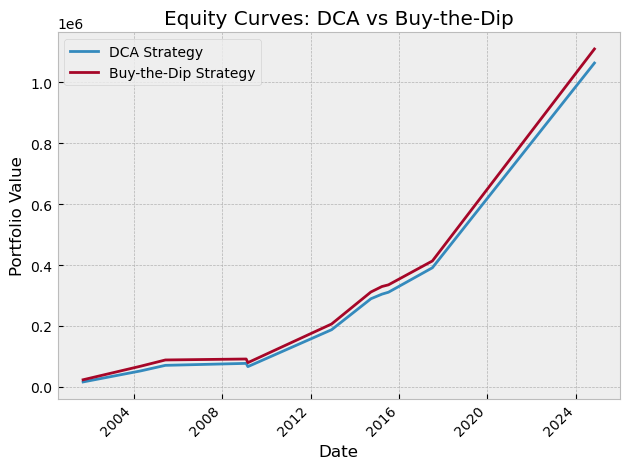

,Strategy,Final Portfolio Value,ROI (%)
0,DCA Strategy,1063726.70,254.58
1,Buy-the-Dip Strategy,1109921.98,269.97


In [613]:
combined = pd.concat([
    monthly_trades['Portfolio Value']
        .rename('DCA Strategy'),
    BD_trades_df['Portfolio_Value']
        .rename('Buy-the-Dip Strategy')
], axis=1).dropna()

# — plot them together —
plt.figure(figsize=(10,5))
combined.plot()
plt.title('Equity Curves: DCA vs Buy-the-Dip')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# — compute final value and ROI for each —
initial_capital = 300_000  # same starting cash for both
results = []
for strat in combined.columns:
    final_val = combined[strat].iloc[-1]
    roi_pct   = (final_val / initial_capital - 1) * 100
    results.append({
        'Strategy': strat,
        'Final Portfolio Value': final_val,
        'ROI (%)': roi_pct
    })

metrics_df = pd.DataFrame(results)
metrics_df


# RSI Strategy